In [534]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable

torch.manual_seed(42)
import torch.nn as nn
from torch.func import functional_call, grad, vmap, jacrev, jacfwd, hessian
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, LBFGS
from torch.optim.lr_scheduler import LambdaLR

from scipy.interpolate import interp2d

[[-5.         -4.97995992 -4.95991984 ...  4.95991984  4.97995992
   5.        ]
 [-5.         -4.97995992 -4.95991984 ...  4.95991984  4.97995992
   5.        ]
 [-5.         -4.97995992 -4.95991984 ...  4.95991984  4.97995992
   5.        ]
 ...
 [-5.         -4.97995992 -4.95991984 ...  4.95991984  4.97995992
   5.        ]
 [-5.         -4.97995992 -4.95991984 ...  4.95991984  4.97995992
   5.        ]
 [-5.         -4.97995992 -4.95991984 ...  4.95991984  4.97995992
   5.        ]]


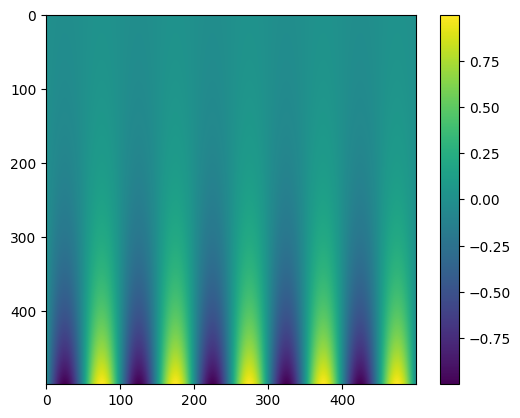

In [535]:
def u(x, t):
    return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 500
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)
us = u(xs, ts)

X, Y = np.meshgrid(xs, ts)
print(X)

U = u(X, Y)

plt.imshow(U)
plt.colorbar()

In [536]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.relu = torch.tanh
        self.lin_1 = nn.Linear(2, 60)
        self.lin_2 = nn.Linear(60, 60)
        self.lin_3 = nn.Linear(60, 1)

    def forward(self, x):
        x = self.lin_1(x)
        x = self.lin_2(self.relu(x))
        x = self.lin_3(self.relu(x))
        return x.squeeze()

""" Define dataset.  self.p instance is to specify IVs and BCs """
class MyDataset(Dataset):

    def __init__(self, inp_tensor, out_tensor):
        self.inp = inp_tensor
        self.out = out_tensor

    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        return self.inp[idx], self.out[idx]

In [537]:
loss_best = 1000

loss_basic_fcn = torch.nn.MSELoss()

def phys_loss(inp, out):
    dudt = torch.autograd.grad(out, [inp], grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,1]
    dudx = torch.autograd.grad(out, [inp], grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,0]
    d2udx2 = torch.autograd.grad(dudx, [inp], grad_outputs=torch.ones_like(dudx), create_graph=True, allow_unused=True)[0][:,0]
    return torch.square(d2udx2-0.5*dudt)

In [538]:
pts = 300
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)
X, T = np.meshgrid(xs, ts)
ts = T.flatten()
xs = X.flatten()
us = u(xs, ts)

assert len(ts) == len(xs)

bdry_pts = 100
xs_bdry = np.linspace(-5, 5, bdry_pts)
ts_bdry = np.asarray([0 for x in xs_bdry])
us_bdry = u(xs_bdry, ts_bdry)

assert len(xs_bdry) == len(ts_bdry) == len(us_bdry)

In [539]:
inp_tensor = torch.tensor([[x, t] for x, t in zip(xs, ts)], dtype=torch.float32, requires_grad=True)
out_tensor = torch.tensor(us, dtype=torch.float32)

inp_tensor_bd = torch.tensor([[x, t] for x, t in zip(xs_bdry, ts_bdry)], dtype=torch.float32, requires_grad=True)
out_tensor_bd = torch.tensor(us_bdry, dtype=torch.float32)

inp_tensor_bd.to(DEVICE)

assert len(inp_tensor) == len(out_tensor)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(DEVICE)

train_dataset = MyDataset(inp_tensor, out_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

adam_epochs = 50
lbfgs_epochs = 10

phys_contrib = 1

optimizer_adam = Adam(model.parameters(), lr=0.1)
scheduler_adam = LambdaLR(optimizer=optimizer_adam,
                          lr_lambda=lambda epoch: 0.995 ** epoch,
                          last_epoch=-1)

for epoch in range(0, adam_epochs):
    for batch_inp, batch_out in train_dataloader:
        batch_size = batch_inp.shape[0]
        batch_inp.to(DEVICE)
        batch_out.to(DEVICE)
        model.train()
        batch_inp = Variable(batch_inp, requires_grad=True)
        def closure_adam():
            optimizer_adam.zero_grad()
            loss = loss_basic_fcn(model(batch_inp), batch_out) + torch.sum(phys_loss(batch_inp, model(batch_inp)))/batch_size + loss_basic_fcn(model(inp_tensor_bd), out_tensor_bd)
            loss.backward()
            return loss
        optimizer_adam.step(closure_adam)
    scheduler_adam.step()

    model.eval()
    basicloss = loss_basic_fcn(model(inp_tensor), out_tensor)
    physloss = torch.sum(phys_loss(inp_tensor, model(inp_tensor)))/batch_size
    boundaryloss = loss_basic_fcn(model(inp_tensor_bd), out_tensor_bd)

    print(f"Epoch: {epoch+1} | Basic: {round(float(basicloss), 4)} | Phys: {round(float(physloss), 4)} | Boundary: {round(float(boundaryloss), 4)}")

optimizer_lbfgs = LBFGS(model.parameters(), lr=0.1)
scheduler_lbfgs = LambdaLR(optimizer=optimizer_lbfgs,
                           lr_lambda=lambda epoch: 0.99 ** epoch,
                           last_epoch=-1)

for epoch in range(0, lbfgs_epochs):
    for batch_inp, batch_out in train_dataloader:
        batch_size = batch_inp.shape[0]
        batch_inp.to(DEVICE)
        batch_out.to(DEVICE)
        model.train()
        batch_inp = Variable(batch_inp, requires_grad=True)
        def closure_lfbgs():
            optimizer_lbfgs.zero_grad()
            loss = loss_basic_fcn(model(batch_inp), batch_out) + torch.sum(phys_loss(batch_inp, model(batch_inp)))/batch_size + loss_basic_fcn(model(inp_tensor_bd), out_tensor_bd)
            loss.backward()
            return loss
        optimizer_lbfgs.step(closure_lfbgs)
    scheduler_lbfgs.step()

    model.eval()
    basicloss = loss_basic_fcn(model(inp_tensor), out_tensor)
    physloss = torch.sum(phys_loss(inp_tensor, model(inp_tensor)))/batch_size
    boundaryloss = loss_basic_fcn(model(inp_tensor_bd), out_tensor_bd)

    print(f"Epoch: {epoch+1} | Basic: {round(float(basicloss), 4)} | Phys: {round(float(physloss), 4)} | Boundary: {round(float(boundaryloss), 4)}")


Epoch: 1 | Basic: 0.0782 | Phys: 0.6679 | Boundary: 0.4762
Epoch: 2 | Basic: 0.0719 | Phys: 2.6406 | Boundary: 0.463
Epoch: 3 | Basic: 0.064 | Phys: 11.6115 | Boundary: 0.4396
Epoch: 4 | Basic: 0.0617 | Phys: 15.7246 | Boundary: 0.4235
Epoch: 5 | Basic: 0.0627 | Phys: 13.3039 | Boundary: 0.4006
Epoch: 6 | Basic: 0.0502 | Phys: 32.7222 | Boundary: 0.3552
Epoch: 7 | Basic: 0.0554 | Phys: 49.9608 | Boundary: 0.32
Epoch: 8 | Basic: 0.0453 | Phys: 46.238 | Boundary: 0.3179
Epoch: 9 | Basic: 0.0421 | Phys: 51.2506 | Boundary: 0.2819
Epoch: 10 | Basic: 0.041 | Phys: 42.3549 | Boundary: 0.2678
Epoch: 11 | Basic: 0.0322 | Phys: 66.5695 | Boundary: 0.2447
Epoch: 12 | Basic: 0.0419 | Phys: 54.43 | Boundary: 0.2507
Epoch: 13 | Basic: 0.0368 | Phys: 61.3903 | Boundary: 0.2456
Epoch: 14 | Basic: 0.0361 | Phys: 53.7605 | Boundary: 0.2482
Epoch: 15 | Basic: 0.0375 | Phys: 61.2956 | Boundary: 0.2473
Epoch: 16 | Basic: 0.045 | Phys: 32.7055 | Boundary: 0.2779
Epoch: 17 | Basic: 0.034 | Phys: 58.3641 | B

KeyboardInterrupt: 

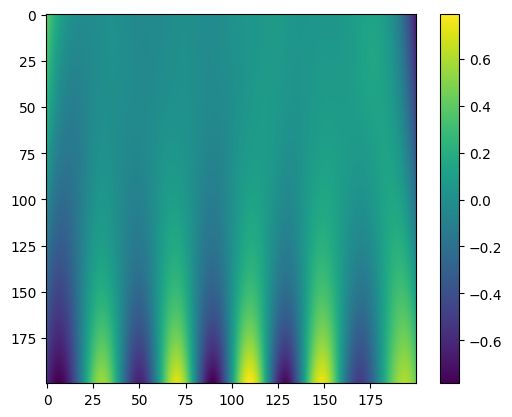

In [532]:
def u_model(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()

In [ ]:
for batch_inp, batch_out in train_dataloader:
    test_inp = batch_inp
    test_out = batch_out
    break

test_inp = Variable(test_inp, requires_grad=True)

print(phys_loss(test_inp, model(test_inp)))
print(model(test_inp))

In [ ]:
test_inp_tensor = torch.tensor(np.linspace(0, 10, 10000), dtype=torch.float32).reshape(10000, -1)

pred_s = model(test_inp_tensor).detach().numpy()

fig, axs = plt.subplots(3, 1, figsize=(6,10))

axs[0].plot(sx, sy, c='b', alpha=0.3, linewidth=4)
axs[0].plot(pred_s[:,0], pred_s[:,1], 'g--')
axs[0].scatter(sx_train, sy_train, c='r', s=3)
axs[0].set_xlim(0, np.max(sx)*2)
axs[0].set_ylim(0, np.max(sy)*2)

axs[1].scatter(t_train, sx_train, c='r', s=4)
axs[1].plot(np.linspace(0, 10, 10000), pred_s[:,0], 'r--')
axs[2].scatter(t_train, sy_train, c='r', s=4)
axs[2].plot(np.linspace(0, 10, 10000), pred_s[:,1], 'r--')

In [ ]:
for batch_inp, batch_out in train_dataloader:
    test_inp = batch_inp
    test_out = batch_out
    break

test_inp = Variable(test_inp, requires_grad=True)

print(phys_loss(test_inp, model(test_inp)))